In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import seaborn as sns
import sqlite3
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import numpy as np
from sklearn.metrics import mean_squared_error
from math import sqrt
import RebapCalc

In [10]:
cnx = sqlite3.connect('Prognosedaten.db')
strSQL = 'SELECT GridLoad.Volume as Load, Rebap.TimeStamp, Rebap.Price as Rebap_Preis, SRL.AbgerMenge_Pos as SRL_AbgerMenge_Pos, SRL.AbgerMenge_Neg as SRL_AbgerMenge_Neg, SRL.Arbeitspreis_Pos as SRL_Arbeitspreis_Pos, SRL.Arbeitspreis_Neg as SRL_Arbeitspreis_Neg, SRL.VorgehMenge_Pos as SRL_VorgehMenge_Pos, SRL.VorgehMenge_Neg as SRL_VorgehMenge_Neg, SRL.Leistungspreis_Pos as SRL_Leistungspreis_Pos, SRL.Leistungspreis_Neg as SRL_Leistungspreis_Neg, MRL.AbgerMenge_Pos as MRL_AbgerMenge_Pos, MRL.AbgerMenge_Neg as MRL_AbgerMenge_Neg, MRL.Arbeitspreis_Pos as MRL_Arbeitspreis_Pos, MRL.Arbeitspreis_Neg as MRL_Arbeitspreis_Neg, MRL.VorgehMenge_Pos as MRL_VorgehMenge_Pos, MRL.VorgehMenge_Neg as MRL_VorgehMenge_Neg, MRL.Leistungspreis_Pos as MRL_Leistungspreis_Pos, MRL.Leistungspreis_Neg as MRL_Leistungspreis_Neg,  Intraday.Price as Intraday_Preis, Intraday.Volume as Intraday_Volume,  Saldo,PV_Ante, WI_Ante, PV_Post, WI_Post, DayAhead.Price as DayAhead_Preis, DayAhead.Volume as DayAhead_Volume  from GridLoad,Rebap, SRL, MRL,Intraday, NRV, RE, DayAhead WHERE SRL.TimeStamp = RE.TimeStamp AND SRL.TimeStamp = GridLoad.TimeStamp AND SRL.TimeStamp = Rebap.TimeStamp AND SRL.TimeStamp = MRL.TimeStamp AND SRL.TimeStamp = Intraday.TimeStamp AND SRL.TimeStamp = NRV.TimeStamp AND SRL.TimeStamp = DayAhead.TimeStamp AND SRL.AbgerMenge_Pos <> "-" AND SRL.AbgerMenge_Neg <> "-" AND SRL.Leistungspreis_Neg <> "-" AND SRL.Leistungspreis_POS <> "-" '

strSQL2 =  'SELECT * from Rebap, Generation_Units WHERE Generation_Units.TimeStamp = Rebap.TimeStamp'

df = pd.read_sql_query(strSQL,cnx)

#df = df.rename(mapper = {"Price": "Rebap_Preis"}, axis = 1)
#df = df.loc[:, ~df.columns.duplicated()]
df["TimeStamp"] = pd.to_datetime(df["TimeStamp"])
df = df.set_index("TimeStamp")
#df = df.drop("TimeStamp.1", axis = 1)
df = df.loc[df.index.year >= 2018]

#df = df.drop("TimeStamp", axis = 1)
#df = df.drop("GridLoad_val",axis=1)
df = df.drop("SRL_VorgehMenge_Pos",axis=1)
df = df.drop("SRL_VorgehMenge_Neg",axis=1)
df = df.drop("SRL_Leistungspreis_Pos",axis=1) 
df = df.drop("SRL_Leistungspreis_Neg",axis=1)
df = df.drop("MRL_VorgehMenge_Pos",axis=1)
df = df.drop("MRL_VorgehMenge_Neg",axis=1)
df = df.drop("MRL_Leistungspreis_Pos",axis=1)
df = df.drop("MRL_Leistungspreis_Neg",axis=1)
#df = df.drop("Intraday_Preis",axis=1)
df = df.drop("Intraday_Volume",axis=1)
#df = df.drop("RE_PV_Ante",axis=1)
#df = df.drop("RE_WI_Ante",axis=1)
#df = df.drop("RE_PV_Post",axis=1) 
#df = df.drop("RE_WI_Post",axis=1)
#df = df.drop("DayAhead_Preis",axis=1)
df = df.drop("DayAhead_Volume",axis=1)
#df["WindErr"] = df["WI_Ante"]- df["WI_Post"]
#df["PVErr"] = df["PV_Ante"] - df["PV_Post"]
df["ResidLoad"] = df["Load"] - df["WI_Ante"] - df["WI_Post"]
df = df.drop(["Load"], axis = 1)
df["REErr"] = df["WI_Ante"]+ df["PV_Ante"] - df["WI_Post"] - df["PV_Post"]
df = df.drop(["PV_Ante", "PV_Post", "WI_Ante", "WI_Post"], axis = 1)

from statsmodels.tsa.statespace.tools import diff
#print(diff(df["Load"]))
#df = df.join(diff(df[["Load"]]).rename(mapper = {"Load": "LoadGrad"}, axis = 1))

print(df.columns)
print(df["Rebap_Preis"].argmax())
df = df.dropna()


Index(['Rebap_Preis', 'SRL_AbgerMenge_Pos', 'SRL_AbgerMenge_Neg',
       'SRL_Arbeitspreis_Pos', 'SRL_Arbeitspreis_Neg', 'MRL_AbgerMenge_Pos',
       'MRL_AbgerMenge_Neg', 'MRL_Arbeitspreis_Pos', 'MRL_Arbeitspreis_Neg',
       'Intraday_Preis', 'Saldo', 'DayAhead_Preis', 'ResidLoad', 'REErr'],
      dtype='object')
12405


In [13]:
trainsize = int(0.8 * len(df.index))
train=df.iloc[:trainsize]#.sample(frac=0.8,random_state=200) #random state is a seed value
test=df.drop(train.index)

rebap_test = (test['Rebap_Preis']).copy().to_numpy()
rebaptemp = test['Rebap_Preis'].copy().to_numpy()
rebap_train = train["Rebap_Preis"].copy().to_numpy()

saldo_train = train["Saldo"].copy().to_numpy()
saldo_test = test["Saldo"].copy().to_numpy()

from seaborn import pairplot
from seaborn import scatterplot, kdeplot, histplot
pdAnalysis   = train.drop(['SRL_AbgerMenge_Pos', 'SRL_Arbeitspreis_Pos', 'SRL_AbgerMenge_Neg','SRL_Arbeitspreis_Neg','MRL_AbgerMenge_Pos', 'MRL_Arbeitspreis_Pos', 'MRL_AbgerMenge_Neg','MRL_Arbeitspreis_Neg'], axis=1)
#pairplot(pdAnalysis, kind ="hist", corner = False)
#plt.savefig("analysis.png")
#plt.close()
from sklearn.ensemble import IsolationForest
#pdAnalysis = pdAnalysis[IsolationForest().fit_predict(pdAnalysis) == 1]
#scatterplot(data = pdAnalysis, y ="Rebap_Preis", hue ="REErr", x= "ResidLoad")
#pairplot(pdAnalysis, kind ="hist")
#plt.savefig("analysisNoOutlier.png")
#plt.close()

pdY_train = train[['SRL_AbgerMenge_Pos', 'SRL_Arbeitspreis_Pos', 'SRL_AbgerMenge_Neg','SRL_Arbeitspreis_Neg','MRL_AbgerMenge_Pos', 'MRL_Arbeitspreis_Pos', 'MRL_AbgerMenge_Neg','MRL_Arbeitspreis_Neg']].copy()
pdX_train = train.drop(['SRL_AbgerMenge_Pos', 'SRL_Arbeitspreis_Pos', 'SRL_AbgerMenge_Neg','SRL_Arbeitspreis_Neg','Saldo','MRL_AbgerMenge_Pos', 'MRL_Arbeitspreis_Pos', 'MRL_AbgerMenge_Neg','MRL_Arbeitspreis_Neg','Rebap_Preis'], axis=1)

pdY_test = test[['SRL_AbgerMenge_Pos', 'SRL_Arbeitspreis_Pos', 'SRL_AbgerMenge_Neg','SRL_Arbeitspreis_Neg','MRL_AbgerMenge_Pos', 'MRL_Arbeitspreis_Pos', 'MRL_AbgerMenge_Neg','MRL_Arbeitspreis_Neg']].copy()
pdX_test = test.drop(['SRL_AbgerMenge_Pos', 'SRL_Arbeitspreis_Pos', 'SRL_AbgerMenge_Neg','SRL_Arbeitspreis_Neg','Saldo','MRL_AbgerMenge_Pos', 'MRL_Arbeitspreis_Pos', 'MRL_AbgerMenge_Neg','MRL_Arbeitspreis_Neg','Rebap_Preis'], axis=1)

AEP4 =  RebapCalc.GetRebap(2000,test['Saldo'].copy().to_numpy(),test['Intraday_Preis'].copy().to_numpy(),test['SRL_Arbeitspreis_Pos'].copy().to_numpy(),test['MRL_Arbeitspreis_Pos'].copy().to_numpy(),test['SRL_Arbeitspreis_Neg'].copy().to_numpy(),test['MRL_Arbeitspreis_Neg'].copy().to_numpy(),test['SRL_AbgerMenge_Pos'].copy().to_numpy(),test['SRL_AbgerMenge_Neg'].copy().to_numpy(),test['MRL_AbgerMenge_Pos'].copy().to_numpy(),test['MRL_AbgerMenge_Neg'].copy().to_numpy())

#plt.plot(rebap_test,color='red',linewidth=0.07)
#plt.plot(AEP4,color='green',linewidth=0.07)
#rms = sqrt(mean_squared_error(AEP4, rebap_test))
#print("RMS: ")
#print(rms)
#plt.show


Xtrain = pdX_train.to_numpy()
Ytrain = pdY_train.to_numpy()

Xtest  = pdX_test.to_numpy()
Ytest  = pdY_test.to_numpy()

print(pdX_train.columns)
print(len(pdAnalysis.index))

print("Data poccessed starting on the ML stuff")


Index(['Intraday_Preis', 'DayAhead_Preis', 'ResidLoad', 'REErr'], dtype='object')
14737
Data poccessed starting on the ML stuff


In [16]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=20)

In [17]:
def get_model():

	model = tf.keras.Sequential()
	model.add(tf.keras.layers.Dense(20, activation='relu', input_shape=[Xtrain.shape[1]]))
	model.add(keras.layers.Dense(20,    activation='relu'))
	model.add(keras.layers.Dense(20,    activation='relu'))
	model.add(keras.layers.Dense(20,    activation='relu'))
	model.add(keras.layers.Dense(20,    activation='relu'))
	model.add(keras.layers.Dense(20,    activation='relu'))
	model.add(keras.layers.Dense(20,    activation='relu'))
	model.add(keras.layers.Dense(20,    activation='relu'))
	model.add(keras.layers.Dense(10,    activation='relu'))
	model.add(tf.keras.layers.Dense(9))
	
	sgd = tf.optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
	rmspop = tf.keras.optimizers.RMSprop(0.001)#chills at 2.3
	model.compile(optimizer=rmspop,loss='mse')
	return model

In [18]:
#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler().fit(Xtrain)
#Xtrain = scaler.transform(Xtrain)
#model = get_model()#Xtrain.shape[1]])
#_ = model.fit(Xtrain,Ytrain,
	#batch_size=64,
	#epochs=100,
	#steps_per_epoch=5,
	#verbose=0,
	#validation_data = (Xtest,Ytest))#,
	#validation_split = 0.2)
	#callbacks=[callback])
#print(pdX_train)
from sklearn.linear_model import LinearRegression, SGDRegressor, HuberRegressor, LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.dummy import DummyRegressor, DummyClassifier
from sklearn.cluster import KMeans
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


model = RandomForestRegressor().fit(Xtrain, rebap_train)
#model = DummyRegressor().fit(Xtrain, rebap_train)
#model = LinearRegression(normalize= True).fit(Xtrain, rebap_train)
def createClasses(rebap):
	return np.where(rebap >= 0 , 1, 0)
#model = DummyClassifier().fit(Xtrain, createClasses(rebap_train))
#pdX_train = train[["Saldo"]]
#Xtrain = train[["Saldo"]].to_numpy()
#Xtest = test[["Saldo"]].to_numpy()
#model = RidgeClassifier().fit(Xtrain,  createClasses(rebap_train))
#model = HuberRegressor().fit(Xtrain, rebap_train)


266.9516286467039
2018-04-25 07:00:00
RMSE Training
20.369980444643662
RMS: 
76.53471500369224


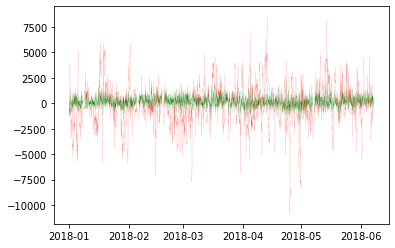

In [19]:
predictions = model.predict(Xtest)
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.inspection import permutation_importance
#importancer = permutation_importance(model, pdX_train, rebap_train,
 #                           n_repeats=30,
#                          random_state=0)
#for i in importancer.importances_mean.argsort():
#    print(f"{pdX_train.columns[i]}" + " " +   f"{importancer.importances_mean[i]}" )

from statsmodels.tsa.arima.model import ARIMA
model2 = ARIMA(saldo_train, order = (1,0,0)).fit(low_memory=True)
print(sqrt(model2.mse))
#print(predictions)
rebapPredict = predictions #(predictions[:,0]*predictions[:,1]+(-1)*predictions[:,2]*predictions[:,3]+predictions[:,5]*predictions[:,6]+(-1)*predictions[:,7]*predictions[:,8])/predictions[:,4]

#rms = sqrt(mean_squared_error(predictions, rebap_test))
#print("RMS: ")
#print(rms)
plt.plot(train["Saldo"],color='green',linewidth=0.07)
plt.plot(train["REErr"],color='red',linewidth=0.07)
print(train.index[train["REErr"].argmin()])
#plt.show()
#maxidx = np.argmax(rebap_test)
#rebap_test1 = np.delete(rebap_test, [maxidx-1, maxidx], axis = 0).copy()
#rebapPredict1 = np.delete(rebapPredict, [maxidx-1, maxidx], axis = 0).copy()

#rebapPredict1 = 1*(np.clip(rebapPredict1, -1000, 1000))

#plot_acf(pdAnalysis["Saldo"], lags = 24*4*7+1)
#plot_pacf(pdAnalysis["Saldo"], lags = 24*4*7+1)
#plt.plot(rebap_test,color='green',linewidth=0.07)
#plt.plot(rebapPredict1,color='red',linewidth=0.07)
#rms = sqrt(mean_squared_error(rebapPredict1, rebap_test1))
#rmstrain = sqrt(mean_squared_error(model.predict(Xtrain), rebap_train))
from sklearn.metrics import accuracy_score
rmstrain = sqrt(mean_squared_error(rebap_train, model.predict(Xtrain)))
rms = sqrt(mean_squared_error(rebap_test, rebapPredict))
print("RMSE Training")
print(rmstrain)
print("RMS: ")
print(rms)
plt.show()